# Dataset Overview

## Data Layout Discovery

In [5]:
from pathlib import Path
DATA_ROOT = Path("/Users/nanzhu/code/Isaac-GR00T/demo_data/cube_to_bowl_5")
CHUNK_GLOB = "chunk-*"

In [6]:
import re
from textwrap import indent
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple

@dataclass
class DatasetLayout:
    root: Path
    meta_dir: Path
    data_dir: Path
    videos_dir: Path
    chunks: List[str]

    # episodes
    parquet_files: List[Path]
    episode_indices: List[int]
    episode_to_parquet: Dict[int, Path]

    # cameras / video keys
    video_keys: List[str]
    # mapping: video_key -> list of mp4 files
    video_files: Dict[str, List[Path]]

    # meta files
    meta_files: Dict[str, Path]  # filename -> path

def _parse_episode_index(p: Path) -> Optional[int]:
    # episode_000123.parquet or episode_000123.mp4
    m = re.search(r"episode_(\d+)\.(parquet|mp4)$", p.name)
    return int(m.group(1)) if m else None

def discover_layout(root: Path, chunk_glob: str = "chunk-*") -> DatasetLayout:
    if not root.exists():
        raise FileNotFoundError(f"DATA_ROOT not found: {root}")

    meta_dir = root / "meta"
    data_dir = root / "data"
    videos_dir = root / "videos"

    # chunks: union from data/chunk-* and videos/chunk-*
    data_chunks = sorted([p.name for p in data_dir.glob(chunk_glob) if p.is_dir()]) if data_dir.exists() else []
    video_chunks = sorted([p.name for p in videos_dir.glob(chunk_glob) if p.is_dir()]) if videos_dir.exists() else []
    chunks = sorted(set(data_chunks + video_chunks))

    # parquet files across chunks
    parquet_files = []
    for ch in chunks:
        parquet_files.extend(sorted((data_dir / ch).glob("episode_*.parquet")))
    parquet_files = sorted(parquet_files)

    episode_indices = []
    episode_to_parquet = {}
    for pq in parquet_files:
        ei = _parse_episode_index(pq)
        if ei is None:
            continue
        episode_indices.append(ei)
        episode_to_parquet[ei] = pq
    episode_indices = sorted(set(episode_indices))

    # discover video keys: videos/chunk-xxx/<video_key>/episode_*.mp4
    video_keys = []
    video_files: Dict[str, List[Path]] = {}
    for ch in chunks:
        ch_dir = videos_dir / ch
        if not ch_dir.exists():
            continue
        for vk_dir in sorted([p for p in ch_dir.iterdir() if p.is_dir()]):
            vk = vk_dir.name
            video_keys.append(vk)
            video_files.setdefault(vk, [])
            video_files[vk].extend(sorted(vk_dir.glob("episode_*.mp4")))

    video_keys = sorted(set(video_keys))
    for vk in video_keys:
        video_files[vk] = sorted(video_files.get(vk, []))

    # meta files
    meta_files = {}
    if meta_dir.exists():
        for p in sorted(meta_dir.iterdir()):
            if p.is_file():
                meta_files[p.name] = p

    return DatasetLayout(
        root=root,
        meta_dir=meta_dir,
        data_dir=data_dir,
        videos_dir=videos_dir,
        chunks=chunks,
        parquet_files=parquet_files,
        episode_indices=episode_indices,
        episode_to_parquet=episode_to_parquet,
        video_keys=video_keys,
        video_files=video_files,
        meta_files=meta_files,
    )



def pretty_layout_summary(layout: DatasetLayout, preview_n: int = 5):
    lines = []

    lines.append("📦 DATASET ROOT")
    lines.append(f"  • Path: {layout.root}")

    lines.append("\n🧩 CHUNKS (data/video shards)")
    if layout.chunks:
        lines.append(f"  • Found {len(layout.chunks)} chunks:")
        for ch in layout.chunks:
            lines.append(f"    - {ch}")
    else:
        lines.append("  ⚠️ No chunks found")

    lines.append("\n🎞️ EPISODES (from parquet files)")
    lines.append(f"  • Total episodes discovered: {len(layout.episode_indices)}")
    if layout.episode_indices:
        preview = layout.episode_indices[:preview_n]
        lines.append(f"  • Episode index preview: {preview}"
                     + ("" if len(layout.episode_indices) <= preview_n else " ..."))

    lines.append("\n📹 VIDEO KEYS (camera / image modalities)")
    lines.append(f"  • Total video keys (cameras): {len(layout.video_keys)}")
    if layout.video_keys:
        preview = layout.video_keys[:preview_n]
        lines.append(f"  • Video key preview: {preview}"
                     + ("" if len(layout.video_keys) <= preview_n else " ..."))

    lines.append("\n📁 META FILES")
    if layout.meta_files:
        lines.append(f"  • Meta files found: {list(layout.meta_files.keys())}")
    else:
        lines.append("  ⚠️ No meta files found")

    return "\n".join(lines)


layout = discover_layout(DATA_ROOT, CHUNK_GLOB)
print(pretty_layout_summary(layout))


📦 DATASET ROOT
  • Path: /Users/nanzhu/code/Isaac-GR00T/demo_data/cube_to_bowl_5

🧩 CHUNKS (data/video shards)
  • Found 1 chunks:
    - chunk-000

🎞️ EPISODES (from parquet files)
  • Total episodes discovered: 5
  • Episode index preview: [0, 1, 2, 3, 4]

📹 VIDEO KEYS (camera / image modalities)
  • Total video keys (cameras): 2
  • Video key preview: ['observation.images.front', 'observation.images.wrist']

📁 META FILES
  • Meta files found: ['episodes.jsonl', 'info.json', 'modality.json', 'relative_stats.json', 'stats.json', 'tasks.jsonl']


## Feature Summary

In [7]:
import json

def read_json(path: Path) -> dict:
    return json.loads(path.read_text())

info = None
info_path = layout.meta_files.get("info.json")
if info_path and info_path.exists():
    info = read_json(info_path)

summary = {
    "root": str(layout.root),
    "chunks": layout.chunks,
    "num_parquet_files": len(layout.parquet_files),
    "num_episodes_found": len(layout.episode_indices),
    "video_keys": layout.video_keys,
    "num_video_keys": len(layout.video_keys),
    "meta_files": sorted(layout.meta_files.keys()),
}

# enrich from info.json if present
if info is not None:
    summary.update({
        "codebase_version": info.get("codebase_version"),
        "robot_type": info.get("robot_type"),
        "total_episodes(meta)": info.get("total_episodes"),
        "total_frames(meta)": info.get("total_frames"),
        "fps(meta)": info.get("fps"),
        "total_videos(meta)": info.get("total_videos"),
        "data_path_template": info.get("data_path"),
        "video_path_template": info.get("video_path"),
        "num_features(meta)": len(info.get("features", {})),
        "feature_keys(meta)": sorted(list(info.get("features", {}).keys()))[:20],
    })

summary


{'root': '/Users/nanzhu/code/Isaac-GR00T/demo_data/cube_to_bowl_5',
 'chunks': ['chunk-000'],
 'num_parquet_files': 5,
 'num_episodes_found': 5,
 'video_keys': ['observation.images.front', 'observation.images.wrist'],
 'num_video_keys': 2,
 'meta_files': ['episodes.jsonl',
  'info.json',
  'modality.json',
  'relative_stats.json',
  'stats.json',
  'tasks.jsonl'],
 'codebase_version': 'v2.1',
 'robot_type': 'so101_follower',
 'total_episodes(meta)': 5,
 'total_frames(meta)': 4148,
 'fps(meta)': 30,
 'total_videos(meta)': 10,
 'data_path_template': 'data/chunk-{episode_chunk:03d}/episode_{episode_index:06d}.parquet',
 'video_path_template': 'videos/chunk-{episode_chunk:03d}/{video_key}/episode_{episode_index:06d}.mp4',
 'num_features(meta)': 9,
 'feature_keys(meta)': ['action',
  'episode_index',
  'frame_index',
  'index',
  'observation.images.front',
  'observation.images.wrist',
  'observation.state',
  'task_index',
  'timestamp']}

## Sanity Check

In [9]:
import pandas as pd
from collections import defaultdict

def episode_coverage_report(layout: DatasetLayout) -> pd.DataFrame:
    """
    Return a table:
      key_type | key_name | episodes_present | episodes_missing | coverage_ratio
    key_type includes: parquet, video
    """
    all_eps = set(layout.episode_indices)

    rows = []

    # Parquet coverage (baseline)
    parquet_eps = set(layout.episode_to_parquet.keys())
    rows.append({
        "key_type": "parquet",
        "key_name": "data",
        "episodes_present": len(parquet_eps),
        "episodes_missing": len(all_eps - parquet_eps),
        "coverage_ratio": (len(parquet_eps) / max(1, len(all_eps))),
        "missing_examples": sorted(list(all_eps - parquet_eps))[:10],
    })

    # Video coverage per key
    for vk in layout.video_keys:
        files = layout.video_files.get(vk, [])
        have = set()
        for f in files:
            ei = _parse_episode_index(f)
            if ei is not None:
                have.add(ei)

        miss = sorted(list(all_eps - have))
        rows.append({
            "key_type": "video",
            "key_name": vk,
            "episodes_present": len(have),
            "episodes_missing": len(miss),
            "coverage_ratio": (len(have) / max(1, len(all_eps))),
            "missing_examples": miss[:10],
        })

    df = pd.DataFrame(rows).sort_values(["key_type", "coverage_ratio", "key_name"], ascending=[True, True, True])
    return df

def validate_layout(layout: DatasetLayout, info: dict | None = None) -> dict:
    """
    Returns a structured validation report:
      - summary: high-level counts
      - coverage: per-key episode coverage table
      - meta_counts_check: compare vs info.json (optional)
    Raises on hard errors.
    """
    # Hard errors
    if not layout.root.exists():
        raise FileNotFoundError(f"DATA_ROOT not found: {layout.root}")
    if not layout.data_dir.exists():
        raise FileNotFoundError(f"Missing data dir: {layout.data_dir}")
    if not layout.videos_dir.exists():
        raise FileNotFoundError(f"Missing videos dir: {layout.videos_dir}")
    if len(layout.episode_indices) == 0:
        raise RuntimeError("No episodes found (no episode_*.parquet under data/).")

    # Coverage table (your main “sanity check”)
    coverage = episode_coverage_report(layout)

    # High-level summary
    summary = {
        "root": str(layout.root),
        "chunks": layout.chunks,
        "episodes_found": len(layout.episode_indices),
        "parquet_files_found": len(layout.parquet_files),
        "video_keys_found": len(layout.video_keys),
        "videos_found_total": int(sum(len(v) for v in layout.video_files.values())),
        "meta_files_found": sorted(layout.meta_files.keys()),
    }

    # Optional: compare against info.json
    meta_counts_check = None
    if info is not None:
        meta_counts_check = {
            "info.total_episodes": info.get("total_episodes"),
            "info.total_videos": info.get("total_videos"),
            "episodes_found": len(layout.episode_indices),
            "videos_found_total": int(sum(len(v) for v in layout.video_files.values())),
            "match_total_episodes": (info.get("total_episodes") == len(layout.episode_indices)) if isinstance(info.get("total_episodes"), int) else None,
            "match_total_videos": (info.get("total_videos") == int(sum(len(v) for v in layout.video_files.values()))) if isinstance(info.get("total_videos"), int) else None,
        }

    return {
        "summary": summary,
        "coverage": coverage,
        "meta_counts_check": meta_counts_check,
    }

report = validate_layout(layout, info)
print("✅ Layout validated.\n")
print("SUMMARY:")
for k, v in report["summary"].items():
    print(f"  • {k}: {v}")

print("\nCOVERAGE (per key):")
display(report["coverage"].sort_values(["key_type","key_name"]))

if report["meta_counts_check"] is not None:
    print("\nINFO.JSON COUNT CHECK:")
    for k, v in report["meta_counts_check"].items():
        print(f"  • {k}: {v}")


✅ Layout validated.

SUMMARY:
  • root: /Users/nanzhu/code/Isaac-GR00T/demo_data/cube_to_bowl_5
  • chunks: ['chunk-000']
  • episodes_found: 5
  • parquet_files_found: 5
  • video_keys_found: 2
  • videos_found_total: 10
  • meta_files_found: ['episodes.jsonl', 'info.json', 'modality.json', 'relative_stats.json', 'stats.json', 'tasks.jsonl']

COVERAGE (per key):


,key_type,key_name,episodes_present,episodes_missing,coverage_ratio,missing_examples
0,parquet,data,5,0,1.0,[]
1,video,observation.images.front,5,0,1.0,[]
2,video,observation.images.wrist,5,0,1.0,[]



INFO.JSON COUNT CHECK:
  • info.total_episodes: 5
  • info.total_videos: 10
  • episodes_found: 5
  • videos_found_total: 10
  • match_total_episodes: True
  • match_total_videos: True


# Schema

In [11]:
import json
from pathlib import Path

def read_json(path: Path) -> dict:
    return json.loads(path.read_text())

def read_jsonl(path: Path, max_lines: int | None = None) -> list[dict]:
    rows = []
    with path.open() as f:
        for i, line in enumerate(f):
            if max_lines is not None and i >= max_lines:
                break
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

meta = {}
for name in ["info.json", "modality.json", "tasks.jsonl", "episodes.jsonl", "stats.json", "relative_stats.json"]:
    p = layout.meta_files.get(name)
    if p and p.exists():
        if name.endswith(".json"):
            meta[name] = read_json(p)
        elif name.endswith(".jsonl"):
            # just sample for schema preview
            meta[name] = read_jsonl(p, max_lines=50)

info = meta.get("info.json")
modality = meta.get("modality.json")
tasks_sample = meta.get("tasks.jsonl")   # list[dict] sample
episodes_sample = meta.get("episodes.jsonl")  # list[dict] sample

print("Loaded meta:")
for k in meta.keys():
    v = meta[k]
    if isinstance(v, list):
        print(f"  • {k}: {len(v)} lines sampled")
    else:
        print(f"  • {k}: dict with {len(v)} keys")


Loaded meta:
  • info.json: dict with 13 keys
  • modality.json: dict with 4 keys
  • tasks.jsonl: 2 lines sampled
  • episodes.jsonl: 5 lines sampled
  • stats.json: dict with 3 keys
  • relative_stats.json: dict with 1 keys


## Feature Table

In [12]:
import pandas as pd

def build_feature_table(info: dict) -> pd.DataFrame:
    feats = info.get("features", {})
    rows = []
    for k, v in feats.items():
        rows.append({
            "feature": k,
            "dtype": v.get("dtype"),
            "shape": v.get("shape"),
            "names": v.get("names"),
            # video extra info if present
            "video.codec": (v.get("info") or {}).get("video.codec"),
            "video.fps": (v.get("info") or {}).get("video.fps"),
            "video.height": (v.get("info") or {}).get("video.height"),
            "video.width": (v.get("info") or {}).get("video.width"),
            "storage_hint": "video" if v.get("dtype") == "video" else "parquet",
        })
    df = pd.DataFrame(rows)

    # Heuristic storage classification
    def classify_storage(row):
        f = row["feature"]
        if row["dtype"] == "video" or str(f).startswith("observation.images"):
            return "video(mp4)"
        if f in ["index", "episode_index", "frame_index", "task_index", "timestamp"]:
            return "index(parquet)"
        return "parquet"

    df["storage"] = df.apply(classify_storage, axis=1)
    df = df.sort_values(["storage", "feature"]).reset_index(drop=True)
    return df

feature_df = build_feature_table(info)
display(feature_df)


,feature,dtype,shape,names,video.codec,video.fps,video.height,video.width,storage_hint,storage
0,episode_index,int64,[1],None,None,NaN,NaN,NaN,parquet,index(parquet)
1,frame_index,int64,[1],None,None,NaN,NaN,NaN,parquet,index(parquet)
2,index,int64,[1],None,None,NaN,NaN,NaN,parquet,index(parquet)
3,task_index,int64,[1],None,None,NaN,NaN,NaN,parquet,index(parquet)
4,timestamp,float32,[1],None,None,NaN,NaN,NaN,parquet,index(parquet)
5,action,float32,[6],"[shoulder_pan.pos, shoulder_lift.pos, elbow_fl...",None,NaN,NaN,NaN,parquet,parquet
6,observation.state,float32,[6],"[shoulder_pan.pos, shoulder_lift.pos, elbow_fl...",None,NaN,NaN,NaN,parquet,parquet
7,observation.images.front,video,"[480, 640, 3]","[height, width, channels]",av1,30.0,480.0,640.0,video,video(mp4)
8,observation.images.wrist,video,"[480, 640, 3]","[height, width, channels]",av1,30.0,480.0,640.0,video,video(mp4)


# Modality Analysis

In [17]:
import pandas as pd

# Convention bindings (make implicit contract explicit)
DEFAULT_BASE_KEY = {
    "state": "observation.state",
    "action": "action",
}

def build_lineage_modality_table(modality: dict) -> pd.DataFrame:
    rows = []
    for mod_name, mod_spec in modality.items():
        if not isinstance(mod_spec, dict):
            # unexpected format; keep raw
            rows.append({
                "modality": mod_name,
                "logical_key": None,
                "base_physical_key": None,
                "transform_type": "raw",
                "slice_start": None,
                "slice_end": None,
                "lookup_key": None,
                "mapping_raw": mod_spec,
            })
            continue

        for logical_key, mapping in mod_spec.items():
            # Case A: slice mapping (start/end)
            if isinstance(mapping, dict) and ("start" in mapping and "end" in mapping):
                base = DEFAULT_BASE_KEY.get(mod_name)  # <-- explicit now
                rows.append({
                    "modality": mod_name,
                    "logical_key": logical_key,
                    "base_physical_key": base,
                    "transform_type": "slice",
                    "slice_start": int(mapping["start"]),
                    "slice_end": int(mapping["end"]),
                    "lookup_key": None,
                    "mapping_raw": mapping,
                })
                continue

            # Case B: direct mapping (original_key)
            if isinstance(mapping, dict) and ("original_key" in mapping):
                base = mapping.get("original_key")
                # annotation is usually lookup: logical text from task_index etc.
                ttype = "lookup" if mod_name == "annotation" else "identity"
                rows.append({
                    "modality": mod_name,
                    "logical_key": logical_key,
                    "base_physical_key": base,
                    "transform_type": ttype,
                    "slice_start": None,
                    "slice_end": None,
                    "lookup_key": base if ttype == "lookup" else None,
                    "mapping_raw": mapping,
                })
                continue

            # Case C: unknown mapping format
            rows.append({
                "modality": mod_name,
                "logical_key": logical_key,
                "base_physical_key": DEFAULT_BASE_KEY.get(mod_name),
                "transform_type": "unknown",
                "slice_start": None,
                "slice_end": None,
                "lookup_key": None,
                "mapping_raw": mapping,
            })

    df = pd.DataFrame(rows).sort_values(["modality", "transform_type", "logical_key"]).reset_index(drop=True)
    return df

lineage_modality_df = build_lineage_modality_table(modality)
display(lineage_modality_df)


,modality,logical_key,base_physical_key,transform_type,slice_start,slice_end,lookup_key,mapping_raw
0,action,gripper,action,slice,5.0,6.0,None,"{'start': 5, 'end': 6}"
1,action,single_arm,action,slice,0.0,5.0,None,"{'start': 0, 'end': 5}"
2,annotation,human.task_description,task_index,lookup,NaN,NaN,task_index,{'original_key': 'task_index'}
3,state,gripper,observation.state,slice,5.0,6.0,None,"{'start': 5, 'end': 6}"
4,state,single_arm,observation.state,slice,0.0,5.0,None,"{'start': 0, 'end': 5}"
5,video,front,observation.images.front,identity,NaN,NaN,None,{'original_key': 'observation.images.front'}
6,video,wrist,observation.images.wrist,identity,NaN,NaN,None,{'original_key': 'observation.images.wrist'}


In [18]:
# Build lookup: feature -> storage from feature_df (built from info.json)
feature_storage = dict(zip(feature_df["feature"], feature_df["storage"]))

def infer_storage(base_physical_key: str | None, transform_type: str) -> str:
    if base_physical_key is None:
        return "unknown"
    # If the base key is a known feature in info.json, use that
    if base_physical_key in feature_storage:
        return feature_storage[base_physical_key]
    # For lookup keys (e.g., task_index), the base key is in parquet,
    # but the produced logical value is meta-derived (needs dimension table)
    if transform_type == "lookup":
        return "meta-derived (lookup via meta/*.jsonl)"
    return "unknown"

contract_df = lineage_modality_df.copy()
contract_df["storage"] = contract_df.apply(
    lambda r: infer_storage(r["base_physical_key"], r["transform_type"]),
    axis=1
)

# a compact view (the one you'll likely show in the notebook / report)
display(contract_df[[
    "modality", "logical_key",
    "base_physical_key", "transform_type",
    "slice_start", "slice_end",
    "storage"
]].sort_values(["modality","logical_key"]))


,modality,logical_key,base_physical_key,transform_type,slice_start,slice_end,storage
0,action,gripper,action,slice,5.0,6.0,parquet
1,action,single_arm,action,slice,0.0,5.0,parquet
2,annotation,human.task_description,task_index,lookup,NaN,NaN,index(parquet)
3,state,gripper,observation.state,slice,5.0,6.0,parquet
4,state,single_arm,observation.state,slice,0.0,5.0,parquet
5,video,front,observation.images.front,identity,NaN,NaN,video(mp4)
6,video,wrist,observation.images.wrist,identity,NaN,NaN,video(mp4)


# Episode Analysis

In [51]:
from IPython.display import display, Markdown

def find_episode_files(layout, episode_index: int):
    pq = layout.episode_to_parquet.get(episode_index)
    if pq is None or not pq.exists():
        raise FileNotFoundError(f"Parquet not found for episode {episode_index}")

    mp4s = {}
    # build episode->path mapping per key (fast enough for demo scale)
    for vk in layout.video_keys:
        p = None
        for f in layout.video_files.get(vk, []):
            ei = _parse_episode_index(f)
            if ei == episode_index:
                p = f
                break
        mp4s[vk] = p  # may be None
    return pq, mp4s

def render_episode_locator(layout, episode_index: int):
    pq, mp4s = find_episode_files(layout, episode_index)
    lines = []
    lines.append(f"## Episode {episode_index:06d} — File Locator")
    lines.append(f"- **Parquet**: `{pq}`")
    lines.append(f"- **Video keys**: {', '.join(layout.video_keys) if layout.video_keys else '(none)'}")
    for vk, p in mp4s.items():
        if p is None:
            lines.append(f"  - `{vk}`: ❌ missing")
        else:
            lines.append(f"  - `{vk}`: ✅ `{p.name}`")
    display(Markdown("\n".join(lines)))
    return pq, mp4s

# ---- choose an episode here ----
EPISODE_INDEX = layout.episode_indices[2]  
pq_path, mp4_paths = render_episode_locator(layout, EPISODE_INDEX)


## Episode 000002 — File Locator
- **Parquet**: `/Users/nanzhu/code/Isaac-GR00T/demo_data/cube_to_bowl_5/data/chunk-000/episode_000002.parquet`
- **Video keys**: observation.images.front, observation.images.wrist
  - `observation.images.front`: ✅ `episode_000002.mp4`
  - `observation.images.wrist`: ✅ `episode_000002.mp4`

## Step Analysis (Parquet)

In [52]:
import numpy as np
def load_episode_parquet(pq_path: Path) -> pd.DataFrame:
    df = pd.read_parquet(pq_path)
    return df

def check_episode_steps(df: pd.DataFrame):
    T = len(df)
    cols = set(df.columns)

    out = {
        "steps": T,
        "has_frame_index": "frame_index" in cols,
        "has_episode_index": "episode_index" in cols,
        "has_task_index": "task_index" in cols,
    }

    if "frame_index" in cols:
        fi = df["frame_index"].to_numpy()
        out["frame_index_min"] = int(np.min(fi))
        out["frame_index_max"] = int(np.max(fi))
        out["frame_index_monotonic"] = bool(np.all(fi[1:] >= fi[:-1]))
        # check if it looks like 0..T-1
        expected = np.arange(T, dtype=fi.dtype)
        out["frame_index_is_0_to_T-1"] = bool(np.array_equal(fi, expected))
        if not out["frame_index_is_0_to_T-1"]:
            # find first mismatch positions (preview)
            mism = np.where(fi != expected)[0][:10]
            out["frame_index_mismatch_positions_preview"] = mism.tolist()
    else:
        out["frame_index_min"] = None
        out["frame_index_max"] = None
        out["frame_index_monotonic"] = None
        out["frame_index_is_0_to_T-1"] = None

    if "task_index" in cols:
        vc = df["task_index"].value_counts().sort_index()
        out["task_index_unique"] = int(vc.shape[0])
        out["task_index_counts"] = vc.to_dict()
    else:
        out["task_index_unique"] = None
        out["task_index_counts"] = None

    return out

df = load_episode_parquet(pq_path)
episode_check = check_episode_steps(df)

display(Markdown(
    f"## Episode {EPISODE_INDEX:06d} — Parquet Overview\n"
    f"- **Steps (rows)**: {episode_check['steps']}\n"
    f"- **Has frame_index**: {episode_check['has_frame_index']}\n"
    f"- **frame_index range**: {episode_check.get('frame_index_min')} .. {episode_check.get('frame_index_max')}\n"
    f"- **frame_index monotonic**: {episode_check.get('frame_index_monotonic')}\n"
    f"- **frame_index == 0..T-1**: {episode_check.get('frame_index_is_0_to_T-1')}\n"
    f"- **task_index unique**: {episode_check.get('task_index_unique')}\n"
))


## Episode 000002 — Parquet Overview
- **Steps (rows)**: 454
- **Has frame_index**: True
- **frame_index range**: 0 .. 453
- **frame_index monotonic**: True
- **frame_index == 0..T-1**: True
- **task_index unique**: 1


## State/Action Stats

In [53]:
def get_base_column_for_modality(contract_df: pd.DataFrame, modality: str) -> str | None:
    sub = contract_df[(contract_df["modality"] == modality) & contract_df["base_physical_key"].notna()]
    if sub.empty:
        return None
    # For state/action typically all rows share same base_physical_key
    keys = sorted(sub["base_physical_key"].unique().tolist())
    return keys[0] if len(keys) == 1 else keys  # could be list in exotic cases

def vector_column_stats(df: pd.DataFrame, col: str, n_preview: int = 3):
    arr = np.stack(df[col].to_numpy())
    stats = {
        "col": col,
        "shape": arr.shape,  # (T, D)
        "dtype": str(arr.dtype),
        "has_nan": bool(np.isnan(arr).any()) if np.issubdtype(arr.dtype, np.floating) else False,
        "min": float(np.min(arr)) if np.issubdtype(arr.dtype, np.number) else None,
        "max": float(np.max(arr)) if np.issubdtype(arr.dtype, np.number) else None,
        "mean": float(np.mean(arr)) if np.issubdtype(arr.dtype, np.number) else None,
        "preview_rows": arr[:n_preview].tolist(),
    }
    return stats

state_base = get_base_column_for_modality(contract_df, "state")
action_base = get_base_column_for_modality(contract_df, "action")

display(Markdown(f"## Episode {EPISODE_INDEX:06d} — State/Action Base Columns\n"
                 f"- **state base column**: `{state_base}`\n"
                 f"- **action base column**: `{action_base}`\n"))

stats_rows = []
for base in [state_base, action_base]:
    if isinstance(base, str) and base in df.columns:
        s = vector_column_stats(df, base, n_preview=2)
        stats_rows.append({
            "base_column": s["col"],
            "shape(T,D)": s["shape"],
            "dtype": s["dtype"],
            "has_nan": s["has_nan"],
            "min": s["min"],
            "max": s["max"],
            "mean": s["mean"],
        })

display(pd.DataFrame(stats_rows))


## Episode 000002 — State/Action Base Columns
- **state base column**: `observation.state`
- **action base column**: `action`


,base_column,"shape(T,D)",dtype,has_nan,min,max,mean
0,observation.state,"(454, 6)",float32,False,-99.399399,100.0,17.241125
1,action,"(454, 6)",float32,False,-99.648811,100.0,16.256521


## task description

In [54]:
def build_task_map(tasks_path: Path) -> dict[int, str]:
    tasks = read_jsonl(tasks_path, max_lines=None)
    # common field name candidates
    def get_desc(t):
        return (t.get("task_description")
                or t.get("description")
                or t.get("task")
                or t.get("text")
                or t.get("instruction")
                or t.get("human.task_description"))
    task_map = {}
    for i, t in enumerate(tasks):
        idx = t.get("task_index", i)
        try:
            idx = int(idx)
        except Exception:
            continue
        task_map[idx] = get_desc(t)
    return task_map

tasks_path = layout.meta_files.get("tasks.jsonl")
task_map = build_task_map(tasks_path) if tasks_path else {}

if "task_index" in df.columns and task_map:
    uniq = sorted(df["task_index"].unique().tolist())
    lines = [f"## Episode {EPISODE_INDEX:06d} — Task Annotation",
             f"- Unique task_index values: {uniq}"]
    for ti in uniq:
        lines.append(f"  - task_index={ti}: **{task_map.get(int(ti), '(missing description)')}**")
    display(Markdown("\n".join(lines)))
else:
    display(Markdown(
        f"## Episode {EPISODE_INDEX:06d} — Task Annotation\n"
        f"- tasks.jsonl present: {bool(tasks_path)}\n"
        f"- task_index column present: {'task_index' in df.columns}\n"
        f"- (Skipping task description mapping)\n"
    ))


## Episode 000002 — Task Annotation
- Unique task_index values: [0]
  - task_index=0: **cube into yellow bowl**

In [55]:
def video_file_quick_info(p: Path | None):
    if p is None:
        return {"exists": False, "name": None, "size_mb": None}
    return {"exists": True, "name": p.name, "size_mb": round(p.stat().st_size / (1024**2), 2)}

rows = []
for vk, p in mp4_paths.items():
    info_row = {"video_key": vk, **video_file_quick_info(p)}
    rows.append(info_row)

video_quick_df = pd.DataFrame(rows).sort_values("video_key")
display(Markdown(f"## Episode {EPISODE_INDEX:06d} — Video Files (Quick Info)"))
display(video_quick_df)


## Episode 000002 — Video Files (Quick Info)

,video_key,exists,name,size_mb
0,observation.images.front,True,episode_000002.mp4,1.88
1,observation.images.wrist,True,episode_000002.mp4,1.17


## Frame Sampler

In [56]:
import cv2

def read_video_frame_opencv(video_path: Path, frame_index: int):
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {frame_index} from {video_path}")
    # BGR -> RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


In [57]:
def extract_logical_vectors(df: pd.DataFrame, contract_df: pd.DataFrame, step_idx: int):
    """
    Returns:
      state_dict: {logical_key: np.ndarray}
      action_dict: {logical_key: np.ndarray}
    """
    out = {"state": {}, "action": {}}

    row = df.iloc[step_idx]

    for _, r in contract_df.iterrows():
        mod = r["modality"]
        if mod not in ("state", "action"):
            continue

        base = r["base_physical_key"]
        if base not in df.columns:
            continue

        vec = np.asarray(row[base])
        if r["transform_type"] == "slice":
            s, e = int(r["slice_start"]), int(r["slice_end"])
            out[mod][r["logical_key"]] = vec[s:e]
        else:
            out[mod][r["logical_key"]] = vec

    return out["state"], out["action"]


In [58]:
import matplotlib.pyplot as plt


def show_step_view(
    episode_index: int,
    step_index: int,
    video_key: str,
    df: pd.DataFrame,
    mp4_paths: dict,
    contract_df: pd.DataFrame,
    task_map: dict | None = None
):
    # --- video frame ---
    vp = mp4_paths.get(video_key)
    if vp is None:
        raise FileNotFoundError(f"Video key '{video_key}' missing for episode {episode_index}")

    frame = read_video_frame_opencv(vp, step_index)

    # --- state / action ---
    state_dict, action_dict = extract_logical_vectors(df, contract_df, step_index)

    # --- task description ---
    task_desc = None
    if task_map and "task_index" in df.columns:
        ti = int(df.iloc[step_index]["task_index"])
        task_desc = task_map.get(ti)

    # --- render ---
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(frame)
    ax.set_title(f"Episode {episode_index} | {video_key} | step {step_index}")
    ax.axis("off")
    plt.show()

    lines = []
    lines.append(f"### Step {step_index} — Metadata")
    if task_desc:
        lines.append(f"- 🏷 **Task**: {task_desc}")

    lines.append("\n**State**")
    for k, v in state_dict.items():
        lines.append(f"- `{k}`: {np.round(v, 4).tolist()}")

    lines.append("\n**Action**")
    for k, v in action_dict.items():
        lines.append(f"- `{k}`: {np.round(v, 4).tolist()}")

    display(Markdown("\n".join(lines)))


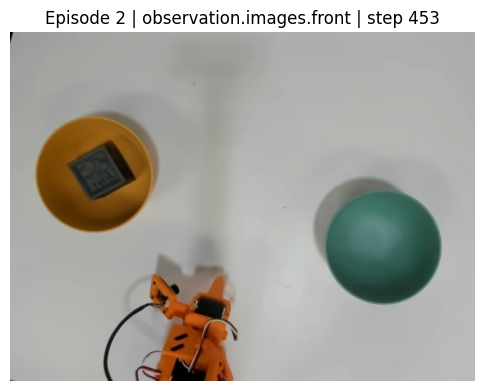

### Step 453 — Metadata
- 🏷 **Task**: cube into yellow bowl

**State**
- `gripper`: [1.020400047302246]
- `single_arm`: [6.435500144958496, -99.29930114746094, 97.49220275878906, 78.470703125, -0.6197999715805054]

**Action**
- `gripper`: [0.9097999930381775]
- `single_arm`: [6.796999931335449, -98.85859680175781, 96.46189880371094, 82.2771987915039, -0.6791999936103821]

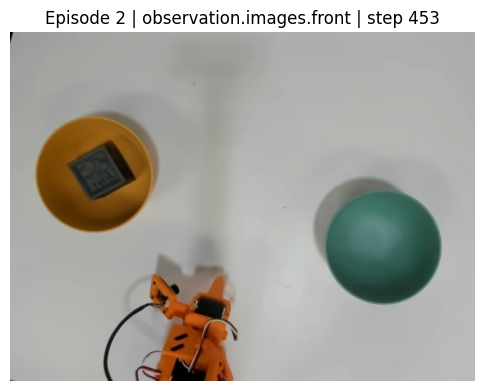

### Step 453 — Metadata
- 🏷 **Task**: cube into yellow bowl

**State**
- `gripper`: [1.020400047302246]
- `single_arm`: [6.435500144958496, -99.29930114746094, 97.49220275878906, 78.470703125, -0.6197999715805054]

**Action**
- `gripper`: [0.9097999930381775]
- `single_arm`: [6.796999931335449, -98.85859680175781, 96.46189880371094, 82.2771987915039, -0.6791999936103821]

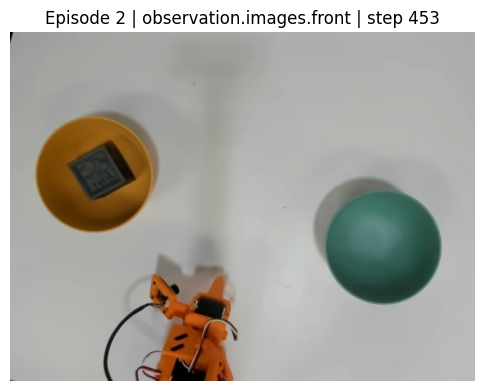

### Step 453 — Metadata
- 🏷 **Task**: cube into yellow bowl

**State**
- `gripper`: [1.020400047302246]
- `single_arm`: [6.435500144958496, -99.29930114746094, 97.49220275878906, 78.470703125, -0.6197999715805054]

**Action**
- `gripper`: [0.9097999930381775]
- `single_arm`: [6.796999931335449, -98.85859680175781, 96.46189880371094, 82.2771987915039, -0.6791999936103821]

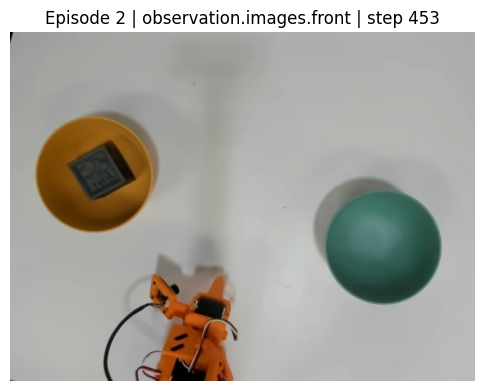

### Step 453 — Metadata
- 🏷 **Task**: cube into yellow bowl

**State**
- `gripper`: [1.020400047302246]
- `single_arm`: [6.435500144958496, -99.29930114746094, 97.49220275878906, 78.470703125, -0.6197999715805054]

**Action**
- `gripper`: [0.9097999930381775]
- `single_arm`: [6.796999931335449, -98.85859680175781, 96.46189880371094, 82.2771987915039, -0.6791999936103821]

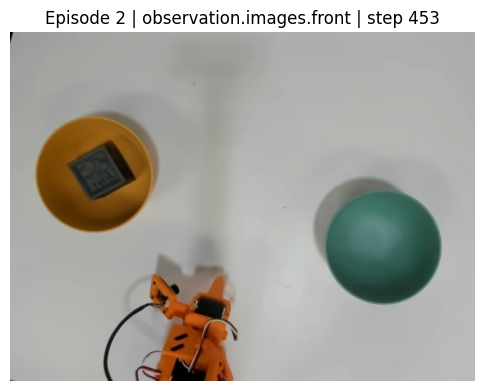

### Step 453 — Metadata
- 🏷 **Task**: cube into yellow bowl

**State**
- `gripper`: [1.020400047302246]
- `single_arm`: [6.435500144958496, -99.29930114746094, 97.49220275878906, 78.470703125, -0.6197999715805054]

**Action**
- `gripper`: [0.9097999930381775]
- `single_arm`: [6.796999931335449, -98.85859680175781, 96.46189880371094, 82.2771987915039, -0.6791999936103821]

In [60]:
import random
import time

def sample_steps_random(T: int, k: int = 10):
    seed = time.time_ns()  
    rng = random.Random(seed)
    k = min(k, T)
    return sorted(rng.sample(range(T), k))


# ---- run ----
T = len(df)
VIDEO_KEY = layout.video_keys[0]  # 0 or 1 in this case

sample_steps = sample_steps_random(T, k=5)

# last_step = T - 1

for s in sample_steps:
    show_step_view(
        episode_index=EPISODE_INDEX,
        step_index=last_step,
        video_key=VIDEO_KEY,
        df=df,
        mp4_paths=mp4_paths,
        contract_df=contract_df,
        task_map=task_map,
    )
